In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import colormaps as cmaps
import os
import scipy as sp
from scipy.ndimage.interpolation import rotate

# Figure 2: Optical Framing

In [2]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\data\2016\s0120B16 C RECONNECTION 12 FRAME\s0120B16

C:\Users\jdavies\Google Drive\MAGPIE\data\2016\s0120B16 C RECONNECTION 12 FRAME\s0120B16


In [3]:
class OpticalFrames:
    def __init__(self, start, IF):
        self.load_images()
        self.normalise()
        self.start=start
        self.IF=IF
        self.frame_times=np.arange(start, start+12*IF, IF)
    def load_images(self):
        shot=os.path.split(os.getcwd())[-1][0:8] #automatically grab the shot number
        b=[]
        s=[]
        for i in range(1,13):
            if i<10:
                st="0"+str(i)
            else:
                st=str(i) 
            bk_fn=shot+" Background_0"+st+".png"
            bk_im=plt.imread(bk_fn) #read background image
            #bk_im=np.asarray(np.sum(bk_im,2), dtype=float)
            b.append(bk_im)#np.asarray(np.sum(bk_im,2), dtype=float)) #convert to grrayscale
            sh_fn=shot+" Shot_0"+st+".png" 
            sh_im=plt.imread(sh_fn)
            s.append(sh_im)
           
        self.shot=shot
        self.b=b
        self.s=s
    def normalise(self):
        norms=[b_im[100:-100,100:-100].sum() for b_im in self.b]
        n_max=max(norms)
        nn=[n/n_max for n in norms]
        self.s_n=[s_im[100:-100,100:-100]/n for s_im, n in zip(self.s, nn)]
    def logarithm(self, lv_min=-4, lv_max=0.2):
        self.s_l=[np.log(s_im) for s_im in self.s_n]
        self.s_nl=[(np.clip(s_im, a_min=lv_min, a_max=lv_max)-lv_min)/(lv_max-lv_min) for s_im in self.s_l]
    def rotate(self, angle_deg=0):
        self.s_r=[rotate(s_im, angle_deg)for s_im in self.s_nl]
    def crop(self, origin, xcrop=400, ycrop=400):
        x0=origin[1]
        y0=origin[0]
        self.origin=[ycrop,xcrop]
        self.s_c=[s_im[y0-ycrop:y0+ycrop,x0-xcrop:x0+xcrop] for s_im in self.s_r]
    def plot(self, array, frame=1, clim=None, ax=None):
        fin=frame-1
        if ax is None:
            fig, ax=plt.subplots(figsize=(12,8))
        ax.imshow(array[fin], cmap='afmhot', clim=clim)
        ax.axis('off')
        ax.set_title('t='+str(self.frame_times[fin])+' ns', fontsize=22)
    def plot_norm(self, frame=1, clim=None, ax=None):
        self.plot(self.s_n, frame=frame, clim=clim, ax=ax)
    def plot_log(self, frame=1, clim=None, ax=None):
        self.plot(self.s_nl, frame=frame, clim=clim, ax=ax)
    def plot_rot(self, frame=1, clim=None, ax=None):
        self.plot(self.s_r, frame=frame, clim=clim, ax=ax)
    def plot_crop(self, frame=1, clim=None, ax=None):
        self.plot(self.s_c, frame=frame, clim=clim, ax=ax)
    def plot_sequence(self, array=None, frames=list(range(1,13)), clim=None, figsize=None):
        xframes=round(len(frames)/2)
        if array is None:
            array=self.s_c
        if figsize is None:
            figsize=(xframes*4,16)
        fig, ax=plt.subplots(2,xframes, figsize=figsize)
        ax=ax.flatten()
        for fin, f in enumerate(frames):
            fn=f-1 #shift to 0 indexed arrays
            a=ax[fin]
            a.imshow(array[fn], cmap='afmhot', clim=clim)
            a.axis('off')
            a.set_title('t='+str(self.frame_times[fn])+' ns', fontsize=22)
        fig.suptitle("Optical Framing images from "+self.shot, fontsize=32)
        fig.tight_layout(w_pad=0, h_pad=0)
        self.fig=fig
    def save_sequence(self, filename=None):
        if filename is None:
            filename=self.shot+" frame sequence"
        self.fig.savefig(filename+".png")        
    def create_lineout(self, axis=0, frame=1,centre=None,average_over_px=20, mm_range=10, scale=29.1, ax=None):
        px_range=mm_range*scale
        fn=frame-1 #shift to 0 indexed arrays
        if axis is 1:
            d=np.transpose(self.s_c[fn])
            y0=self.origin[1] if centre is None else centre
            x0=self.origin[0]
        if axis is 0:
            d=self.s_c[fn]
            y0=self.origin[0] if centre is None else centre
            x0=self.origin[1]
        section=d[y0-average_over_px:y0+average_over_px, x0-px_range:x0+px_range]
        self.lo=np.mean(section, axis=0)
        self.mm=np.linspace(-px_range, px_range, self.lo.size)/scale
        if ax is None:
            fig, ax=plt.subplots(figsize=(12,8))
        ax.plot(self.mm, self.lo, label='t='+str(self.frame_times[fn])+' ns', lw=4)
        

In [4]:
s=OpticalFrames(188,15)
s.logarithm()
s.rotate(-90+25)
s.crop((634,597), xcrop=230, ycrop=300)

C:\Users\jdavies\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: RuntimeWarning: divide by zero encountered in log


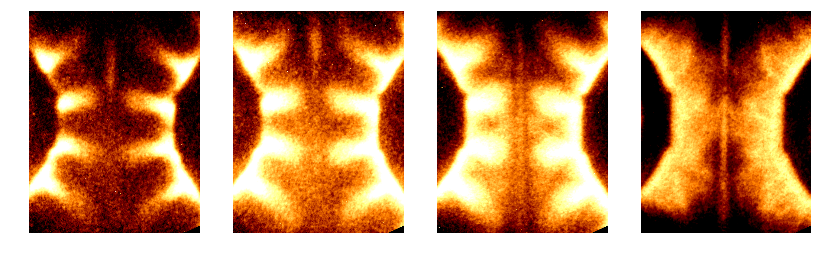

In [5]:
fig, ax=plt.subplots(1,4,figsize=(14,8))
s.plot_crop(frame=1, ax=ax[0], clim=[0.1,0.8])
s.plot_crop(frame=2, ax=ax[1], clim=[0.1,0.8])
s.plot_crop(frame=5, ax=ax[2], clim=[0.2,0.8])
s.plot_crop(frame=11, ax=ax[3], clim=[0.5,1])
for a in ax:
    a.set_title('')

# Figure 3: Interferometry

In [6]:
class NeLMap:
    def __init__(self, filename, scale, multiply_by=1, flip_lr=False):
        d=np.loadtxt(open(filename,"r"),delimiter=",")
        d=d-np.nan_to_num(d).min()
        d=np.nan_to_num(d)
        if flip_lr is True:
            d=np.fliplr(d)
        self.neL=d*multiply_by
        self.scale=scale
    def plot_neL(self, clim=[0,2], ax=None, transpose=False):
        if ax is None:
            fig, ax=plt.subplots(figsize=(12,8))
        d=self.neL/1e18
        if transpose is True:
            d=np.transpose(d)
        ax.imshow(self.neL/1e18)#, cmap='afmhot', interpolation='none', clim=clim)
    def set_origin(self, origin, x_range=11.5, y_range=8.5):
        self.origin=origin
        ymin=origin[0]-y_range*self.scale
        ymax=origin[0]+y_range*self.scale
        xmin=origin[1]-x_range*self.scale
        xmax=origin[1]+x_range*self.scale
        print(ymin,ymax,xmin,xmax)
        self.neL_crop=self.neL[ymin:ymax, xmin:xmax]
        self.extent=[-x_range,x_range,-y_range,y_range]
    def plot_neL_mm(self,clim=[0,2], ax=None, transpose=False, cmap=cmaps.cmaps['inferno']):
        if ax is None:
            fig, ax=plt.subplots(figsize=(12,8))
        d=self.neL_crop/1e18
        ex=self.extent
        if transpose is True:
            d=np.transpose(d)
            ex=ex[2:4]+ex[0:2]
        return ax.imshow(d, cmap=cmap, interpolation='none', clim=clim, extent=ex, aspect=1)
    def create_lineout(self, axis, centre=None,average_over_px=20, mm_range=10):
        px_range=mm_range*self.scale
        if axis is 1:
            d=np.transpose(self.neL)
            y0=self.origin[1] if centre is None else centre
            x0=self.origin[0]
        if axis is 0:
            d=self.neL
            y0=self.origin[0] if centre is None else centre
            x0=self.origin[1]
        section=d[y0-average_over_px:y0+average_over_px, x0-px_range:x0+px_range]
        self.lo=np.mean(section, axis=0)
        self.mm=np.linspace(-px_range, px_range, 2*px_range)/self.scale
    def plot_lineout(self, ax=None, label=''):
        if ax is None:
            fig, ax=plt.subplots(figsize=(12,8))
        ax.plot(self.mm, self.lo/1e18, label=label, lw=4)

In [7]:
%cd "~\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow"

C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow


In [8]:
s1006_15_532=NeLMap('s1006_15 532nm neL.txt', scale=173)
s1006_15_532.set_origin(origin=(1760,2328))
s1006_15_355=NeLMap('s1006_15 355nm neL.txt', scale=128, multiply_by=2, flip_lr=True)
s1006_15_355.set_origin(origin=(1200,1680))

289.5 3230.5 338.5 4317.5
112.0 2288.0 208.0 3152.0


C:\Users\jdavies\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


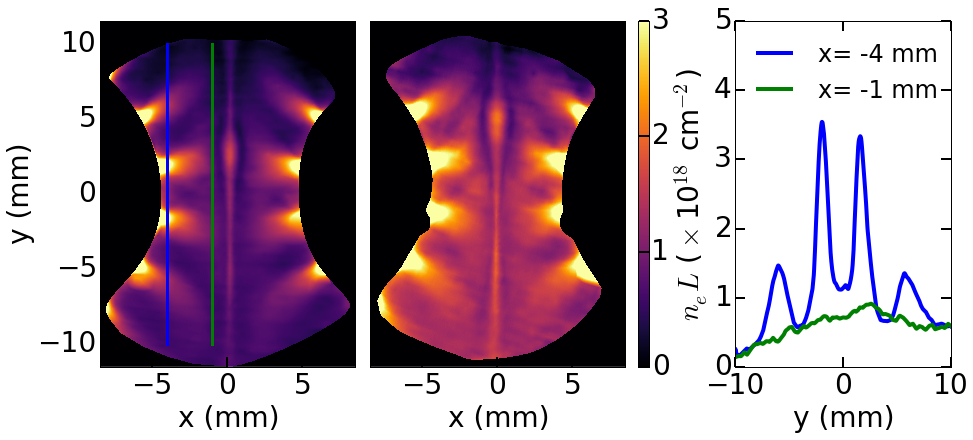

In [9]:
fig=plt.figure(figsize=(15, 6))
ax1=fig.add_axes([0.0, 0.10, 0.3, 0.8])#l,b,w,h
gim=s1006_15_532.plot_neL_mm(ax=ax1, clim=[0,3],transpose=True)

for x_mm in [-4,-1]:
    ax1.plot([x_mm,x_mm],[-10,10], lw=3)

ax2=fig.add_axes([0.25, 0.10, 0.3, 0.8])#l,b,w,h
bim=s1006_15_355.plot_neL_mm(ax=ax2, clim=[0,3],transpose=True)

ax1.set_xlabel('x (mm)',fontsize=28)
ax1.set_ylabel('y (mm)',fontsize=28)
ax2.set_xlabel('x (mm)',fontsize=28)
ax2.set_xticks([-5,0,5])
ax1.set_xticks([-5,0,5])

ax1.set_xlim([-8.5,8.5])
ax1.set_ylim([-11.5,11.5])

ax1.tick_params(labelsize=28, pad=5, length=10, width=2)
ax2.tick_params(labelsize=28, pad=5, length=10, width=2)
plt.setp(ax2.get_yticklabels(), visible=False)

cbar_ax=fig.add_axes([0.53, 0.10, 0.01, 0.8])#l,b,w,h
cbar_ax.tick_params(labelsize=28, pad=5, length=10, width=2)
fig.colorbar(bim, cax=cbar_ax, ticks=[0.0,1,2,3.0])

ax3=fig.add_axes([0.62, 0.10, 0.2, 0.8])#l,b,w,h
s=s1006_15_532
for y_mm in [-4,-1]:
    y_px=s.origin[0]+y_mm*s.scale
    s.create_lineout(axis=0, centre=y_px, mm_range=10)
    s.plot_lineout(ax=ax3, label="x= "+str(y_mm)+" mm")
ax3.set_xlim([-10,10])#
ax3.set_xticks([-10,0,10])#
ax3.set_ylim([0, 5])

ax3.set_xlabel('y (mm)',fontsize=28)
ax3.set_ylabel(r'$n_e L$ ($\times$ 10$^{18}$ cm$^{-2}$)',fontsize=28)
ax3.tick_params(labelsize=28, pad=5, length=10, width=2)
ax3.legend(fontsize=24, loc=9, frameon=False)